In [243]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.observables import nrmse, rsquare

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

In [244]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y, x_lorenz, y_lorenz, z_lorenz = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + x_lorenz
    
    dx_lorenz_dt = sigma * (y_lorenz - x_lorenz)
    dy_lorenz_dt = x_lorenz * (rho - z_lorenz) - y_lorenz
    dz_lorenz_dt = x_lorenz * y_lorenz - beta * z_lorenz
    
    return [dXdt, dYdt, dx_lorenz_dt, dy_lorenz_dt, dz_lorenz_dt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0, 1.0, 1.0, 1.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 2510)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step = 0.01)

In [245]:
data_loaded = pd.read_csv('coupled_system_dataset.csv')

In [246]:
#Time, Van Der Pol　OscillatorのX, lorenzのx項のみを抽出、学習。

data = pd.DataFrame({
    'X': sol.y[0],
    'Y': sol.y[1],
    'x_lorenz': sol.y[2],
    'y_lorenz': sol.y[3],
    'z_lorenz': sol.y[4]
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

In [247]:
X = data.values

In [248]:
X.shape

(25100, 5)

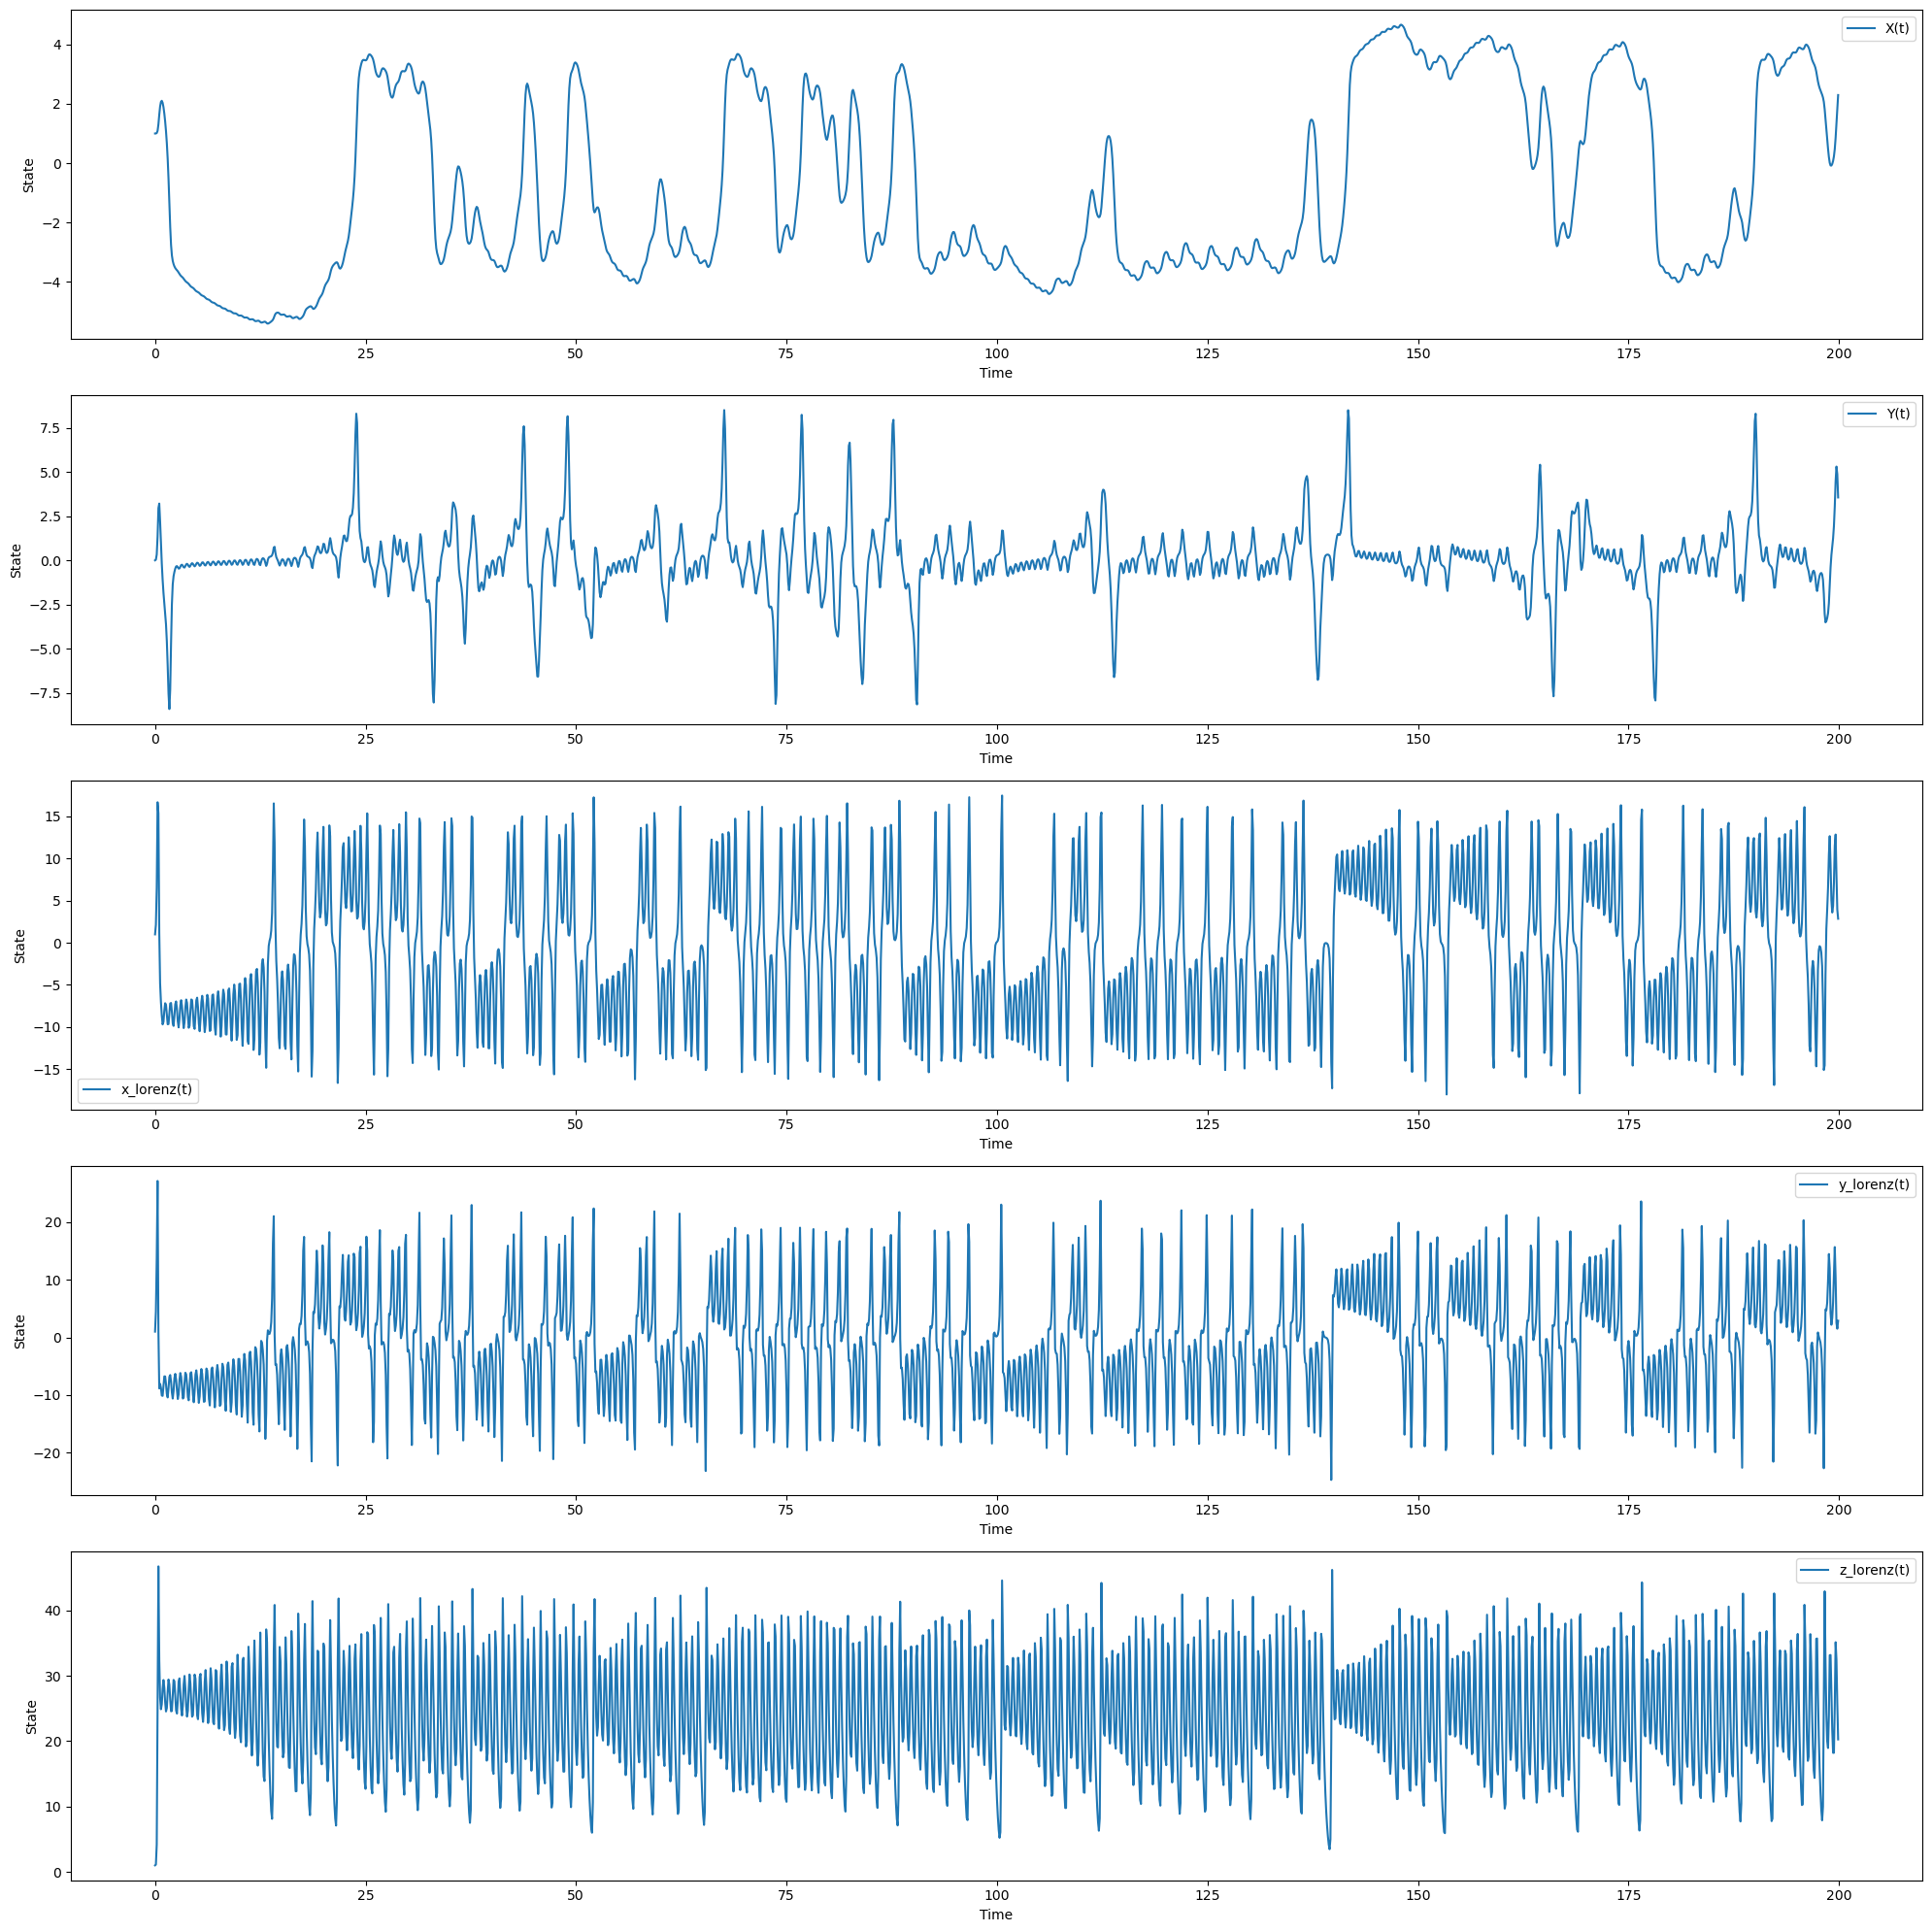

In [249]:
# Plot the results
sample = 2000

plt.figure(figsize=(20, 20))

plt.subplot(5, 1, 1)
plt.plot(sol.t[:sample], sol.y[0][:sample], label='X(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(sol.t[:sample], sol.y[1][:sample], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(sol.t[:sample], sol.y[2][:sample], label='x_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(sol.t[:sample], sol.y[3][:sample], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(sol.t[:sample], sol.y[4][:sample], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

In [303]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    N_value = int(N)  # Nを整数に変換    
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N_value, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test[:, :2], predictions[:, :2], norm_value=np.ptp(X_train))
        r2 = rsquare(y_test[:, :2], predictions[:, :2])
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [304]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["quniform", 500, 5000, 1],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [324]:
from reservoirpy.datasets import to_forecasting

train_len = 15000
test_len = 5000

x, y = to_forecasting(X, forecast=5)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [306]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

  1%|          | 2/200 [03:50<6:02:58, 109.99s/trial, best loss: 0.011565198787486498]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.05687e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.8531e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.60292e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



  2%|▏         | 4/200 [05:24<3:26:14, 63.13s/trial, best loss: 0.01089080257034867]  

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.72492e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.75204e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



  2%|▎         | 5/200 [05:55<2:47:41, 51.60s/trial, best loss: 0.01089080257034867]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.90779e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.01335e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.06853e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



  5%|▌         | 10/200 [16:02<5:53:39, 111.68s/trial, best loss: 0.01089080257034867]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.91028e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.14033e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.55693e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 10%|█         | 21/200 [34:12<3:10:40, 63.91s/trial, best loss: 0.009338019314162132]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.61822e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.38303e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.24596e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 19%|█▉        | 38/200 [1:11:39<4:32:14, 100.83s/trial, best loss: 0.00757558452466887] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.78142e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.42717e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.88217e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 20%|██        | 40/200 [1:15:48<4:32:58, 102.37s/trial, best loss: 0.00757558452466887]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.42993e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.61649e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.70267e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 26%|██▋       | 53/200 [1:46:26<5:04:46, 124.40s/trial, best loss: 0.00757558452466887]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.45824e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.47404e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.09563e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 44%|████▎     | 87/200 [2:34:38<2:23:21, 76.12s/trial, best loss: 0.00757558452466887] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.78525e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.83306e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=7.44156e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 44%|████▍     | 88/200 [2:35:33<2:09:55, 69.60s/trial, best loss: 0.00757558452466887]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.27598e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.30485e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.29126e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 44%|████▍     | 89/200 [2:36:48<2:11:55, 71.31s/trial, best loss: 0.00757558452466887]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.26808e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.82799e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.33481e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 45%|████▌     | 90/200 [2:38:13<2:18:04, 75.32s/trial, best loss: 0.00757558452466887]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.53959e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.56417e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=5.35923e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 46%|████▋     | 93/200 [2:42:28<2:48:56, 94.73s/trial, best loss: 0.00757558452466887]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.12817e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.15602e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.04957e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 59%|█████▉    | 118/200 [3:23:14<3:15:23, 142.98s/trial, best loss: 0.00757558452466887]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.96697e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.65937e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.34905e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 76%|███████▌  | 151/200 [4:22:02<1:21:03, 99.25s/trial, best loss: 0.00757558452466887] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.44237e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.01583e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.51685e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 76%|███████▋  | 153/200 [4:28:34<1:43:00, 131.50s/trial, best loss: 0.00757558452466887]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.28674e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.39854e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.7553e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 81%|████████  | 162/200 [4:38:11<46:58, 74.17s/trial, best loss: 0.00757558452466887]   

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.50205e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.53929e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.17331e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 82%|████████▏ | 164/200 [4:41:55<58:20, 97.23s/trial, best loss: 0.00757558452466887]

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.169e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.67598e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=2.85369e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 85%|████████▌ | 170/200 [4:49:50<31:28, 62.97s/trial, best loss: 0.00757558452466887]   

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.38881e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=6.06305e-18): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.17931e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 89%|████████▉ | 178/200 [5:00:19<24:04, 65.67s/trial, best loss: 0.00757558452466887] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.20632e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.27527e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.48931e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 93%|█████████▎| 186/200 [5:28:46<29:56, 128.32s/trial, best loss: 0.00757558452466887]  

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.20874e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.10834e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.0376e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



 98%|█████████▊| 195/200 [5:39:26<03:29, 41.84s/trial, best loss: 0.00757558452466887] 

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.48399e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.05246e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")

/Users/manqueenmannequin/miniforge3/envs/python38gen2/lib/python3.8/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.00536e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")



100%|██████████| 200/200 [5:50:47<00:00, 105.24s/trial, best loss: 0.00757558452466887]


In [307]:
best

({'N': 4299.0,
  'iss': 0.47860011851145334,
  'lr': 0.4166356911062447,
  'ridge': 1.2751646272541625e-05,
  'seed': 0,
  'sr': 0.14848409471568397},
 <hyperopt.base.Trials at 0x299b1b460>)

In [325]:
# bestから取得したハイパーパラメータを設定
N = 4299
iss = 0.47860011851145334
lr = 0.4166356911062447
ridge = 1.2751646272541625e-05
seed = 1234
sr =  0.14848409471568397

In [326]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [327]:
# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_test)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_test, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.024041118391280883
R^2: 0.9778002956340396


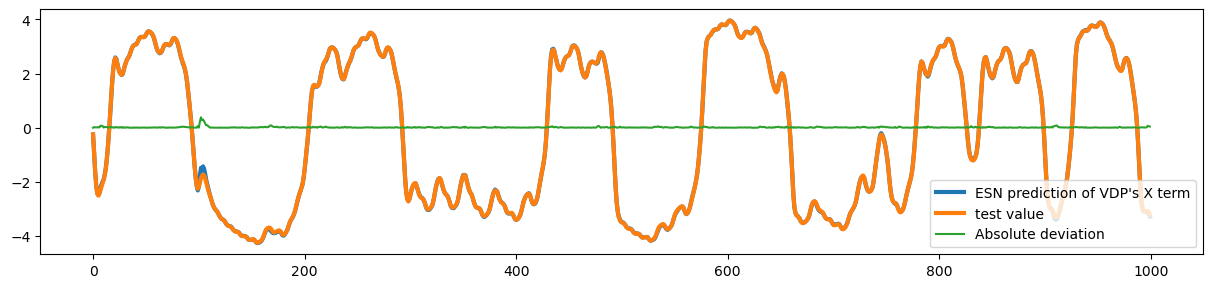

In [328]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, :1][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, :1][:sample] - predictions[:, :1][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

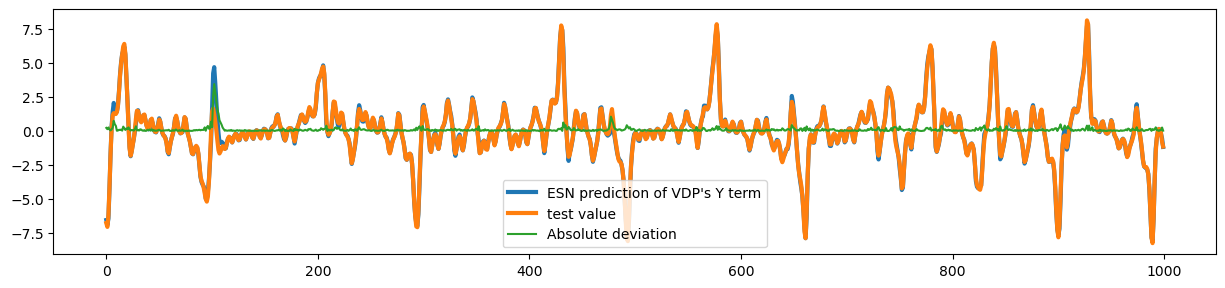

In [329]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

In [330]:
rsquare(y_test, predictions), nrmse(y_test, predictions)

(0.9778002956340396, 0.02511049726174842)

### Generative Modelを使ってみる

考えることは以下の通り

1. Generative modelを更新するごとに、外力に関しては実データを用いる。
2. 一周期$2\pi$で約1日に相当する。最終的には14日程度の予測を行えるようにしたいので、約100程度の予測が出来れば十分である。